In [3]:
# 📌 Cell 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Algorithms for comparison
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb  # If you have xgboost installed
from xgboost import XGBClassifier
import joblib


In [4]:
# 📌 Cell 2: Define constants
DATA_PATH = "Weather.csv" 

In [5]:
# 📌 Cell 3: Load and clean data
def load_and_clean(path=DATA_PATH):
    """Loads data, handles date features, and drops extraneous columns."""
    df = pd.read_csv(path)
    if '@dropdown' in df.columns:
        df = df.drop(columns=['@dropdown'])
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    # Usually Year is high cardinality, skipping it
    return df

df = load_and_clean()
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Day,Month
0,2008-12-01,Delhi,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,1,12
1,2008-12-02,Delhi,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,2,12
2,2008-12-03,Delhi,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,3,12
3,2008-12-04,Delhi,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,4,12
4,2008-12-05,Delhi,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,5,12


In [6]:
# 📌 Cell 4: Prepare target & features
def prepare_target_and_features(df):
    """Prepares target, handles RainToday mapping, and defines feature columns."""
    df = df.dropna(subset=['RainTomorrow']).copy()
    df['RainTomorrow'] = df['RainTomorrow'].map({'No':0, 'Yes':1})
    df['RainToday'] = df['RainToday'].map({'No':0, 'Yes':1})
    
    feature_cols = [
        'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
        'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
        'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
        'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
        'Temp9am', 'Temp3pm', 'RainToday', 'Day', 'Month'
    ]
    feature_cols = [c for c in feature_cols if c in df.columns]
    X = df[feature_cols]
    y = df['RainTomorrow']
    return X, y, feature_cols

X, y, feature_cols = prepare_target_and_features(df)
X.head()


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Day,Month
0,Delhi,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,1,12
1,Delhi,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,2,12
2,Delhi,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,3,12
3,Delhi,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,4,12
4,Delhi,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,5,12


In [7]:
# 📌 Cell 5: Define Preprocessor
def get_preprocessor(numeric_features, categorical_features):
    """Creates the ColumnTransformer for preprocessing."""
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ('num', num_pipeline, numeric_features),
        ('cat', cat_pipeline, categorical_features)
    ])
    return preprocessor


In [8]:
# 📌 Cell 6: Train/Test split
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preprocessor = get_preprocessor(numeric_features, categorical_features)


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay


In [10]:
def evaluate_model(pipeline, X_train, y_train, X_test, y_test, model_name):
    """Trains and evaluates a single model pipeline with Confusion Matrix & ROC Curve."""
    print(f"\n--- Training {model_name} ---")
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    y_prob_test = pipeline.predict_proba(X_test)[:,1] if hasattr(pipeline, 'predict_proba') else None

    # Evaluation metrics
    train_acc = (y_pred_train == y_train).mean()
    test_acc = (y_pred_test == y_test).mean()
    roc_auc = roc_auc_score(y_test, y_prob_test) if y_prob_test is not None else 0.0

    print(f"{model_name} Accuracy (Train): {train_acc:.4f}")
    print(f"{model_name} Accuracy (Test): {test_acc:.4f}")
    print(f"{model_name} ROC AUC: {roc_auc:.4f}")
    
    # Detailed test metrics
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_pred_test))

    # 📌 Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # 📌 ROC AUC Curve
    if y_prob_test is not None:
        RocCurveDisplay.from_predictions(y_test, y_prob_test, name=model_name)
        plt.title(f"ROC Curve - {model_name}")
        plt.show()

    return {'model_name': model_name, 'pipeline': pipeline, 'roc_auc': roc_auc}


In [11]:
# 📌 Cell 8: Define Models
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42),
    'xgboost Classifier': XGBClassifier(eval_metric='logloss', random_state=42),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced'),
    'KNeighbors Classifier': KNeighborsClassifier(n_neighbors=5),
    # 'SVC': SVC(probability=True)  # Uncomment if you want to test SVM
}




--- Training Logistic Regression ---
Logistic Regression Accuracy (Train): 0.7942
Logistic Regression Accuracy (Test): 0.7938
Logistic Regression ROC AUC: 0.8714

Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86     22120
           1       0.52      0.77      0.62      6322

    accuracy                           0.79     28442
   macro avg       0.72      0.79      0.74     28442
weighted avg       0.84      0.79      0.81     28442



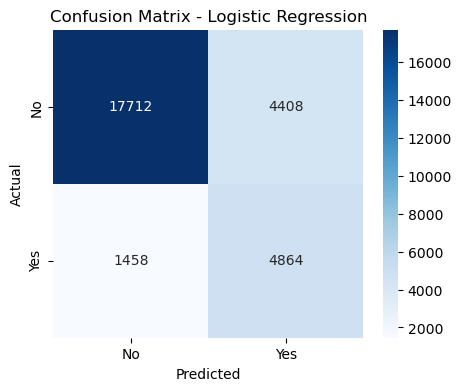

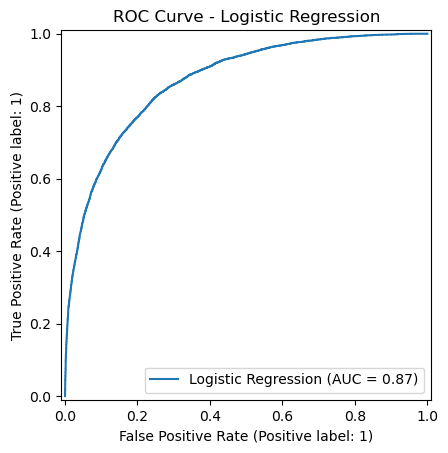


--- Training Decision Tree Classifier ---
Decision Tree Classifier Accuracy (Train): 1.0000
Decision Tree Classifier Accuracy (Test): 0.7934
Decision Tree Classifier ROC AUC: 0.7058

Test Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     22120
           1       0.53      0.55      0.54      6322

    accuracy                           0.79     28442
   macro avg       0.70      0.71      0.70     28442
weighted avg       0.80      0.79      0.79     28442



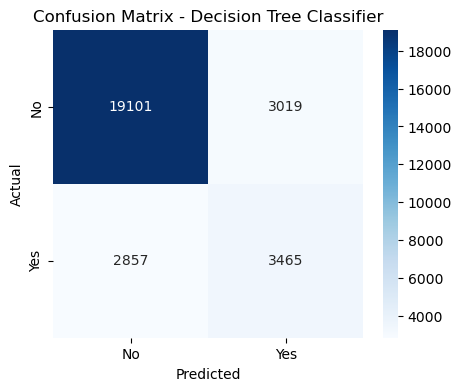

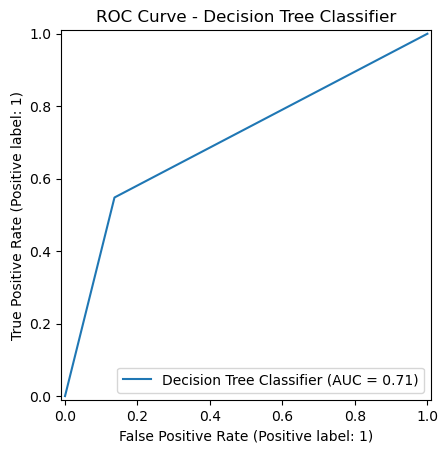


--- Training xgboost Classifier ---
xgboost Classifier Accuracy (Train): 0.8892
xgboost Classifier Accuracy (Test): 0.8616
xgboost Classifier ROC AUC: 0.8936

Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     22120
           1       0.76      0.56      0.64      6322

    accuracy                           0.86     28442
   macro avg       0.82      0.75      0.78     28442
weighted avg       0.85      0.86      0.85     28442



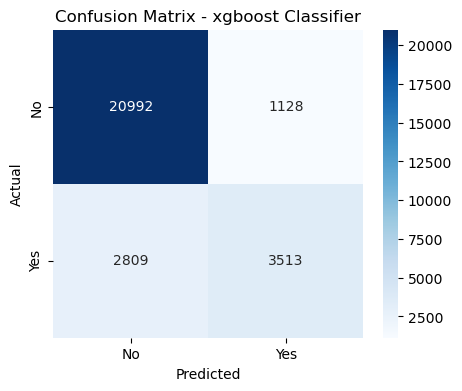

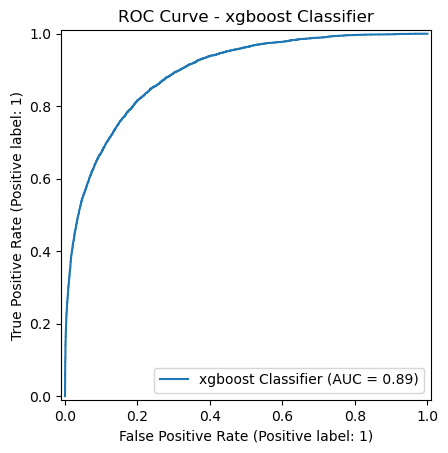


--- Training Random Forest Classifier ---
Random Forest Classifier Accuracy (Train): 1.0000
Random Forest Classifier Accuracy (Test): 0.8555
Random Forest Classifier ROC AUC: 0.8907

Test Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     22120
           1       0.78      0.48      0.60      6322

    accuracy                           0.86     28442
   macro avg       0.82      0.72      0.76     28442
weighted avg       0.85      0.86      0.84     28442



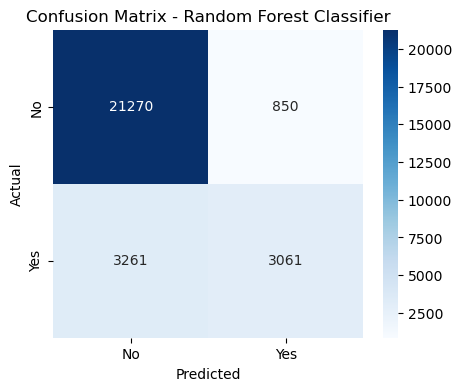

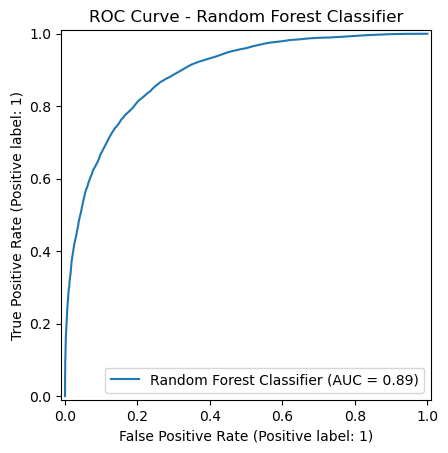


--- Training KNeighbors Classifier ---
KNeighbors Classifier Accuracy (Train): 0.8818
KNeighbors Classifier Accuracy (Test): 0.8355
KNeighbors Classifier ROC AUC: 0.8256

Test Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     22120
           1       0.68      0.48      0.57      6322

    accuracy                           0.84     28442
   macro avg       0.77      0.71      0.73     28442
weighted avg       0.82      0.84      0.82     28442



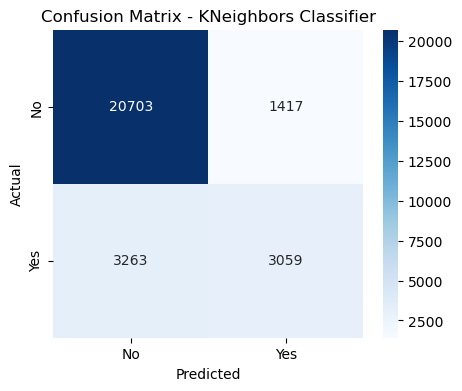

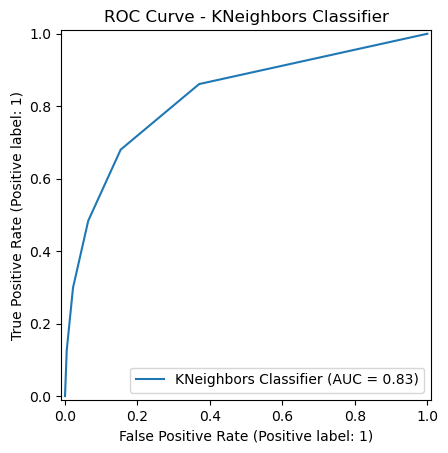

In [12]:
# 📌 Cell 9: Train and compare models
results = []

for name, classifier in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    result = evaluate_model(pipeline, X_train, y_train, X_test, y_test, name)
    results.append(result)


In [13]:
# 📌 Cell 10: Select best model
best_model = max(results, key=lambda x: x['roc_auc'])
print("\n=======================================================")
print(f"BEST MODEL SELECTED: {best_model['model_name']} with ROC AUC: {best_model['roc_auc']:.4f}")
print("=======================================================")



BEST MODEL SELECTED: xgboost Classifier with ROC AUC: 0.8936


In [14]:
# 📌 Cell 11: Save best pipeline
joblib.dump({
    'pipeline': best_model['pipeline'],
    'feature_columns': X.columns.tolist(),
    'numeric_features': numeric_features,
    'categorical_features': categorical_features
}, 'Rainfall_pipeline.pkl')

print(f"Saved best model pipeline to Rainfall_pipeline.pkl ({best_model['model_name']})")

Saved best model pipeline to Rainfall_pipeline.pkl (xgboost Classifier)
